# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:16<00:00, 3.62KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

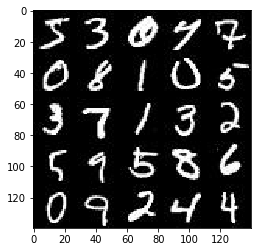

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

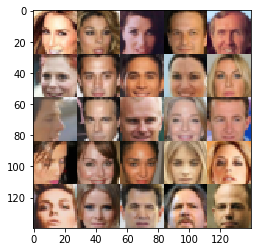

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    #mark_used()
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Applications/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Applications/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Applications/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/Applications/anaconda3/lib/python3.6/site-packages/zmq/eve

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    keep_prob=0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d1 = tf.nn.dropout(c1, keep_prob=keep_prob)
        reul1 = tf.maximum(alpha*d1, d1)
        # 14X14x64
        
        c2 = tf.layers.conv2d(c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d2 = tf.nn.dropout(c2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(d2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        c3 = tf.layers.conv2d(c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d3 = tf.nn.dropout(c3, keep_prob=keep_prob)
        bn3 = tf.layers.batch_normalization(d3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    keep_prob=0.8
    with tf.variable_scope('generator', reuse=not is_train):
        # Project input vector
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='SAME',
                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_faked = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_faked, reuse=True)
    
    # Add smoothing to reduce labels
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=(tf.ones_like(d_model_fake))
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images), np.max(batch_images)))
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 15.7886
Epoch 1/2... Discriminator Loss: 0.6679... Generator Loss: 3.9010
Epoch 1/2... Discriminator Loss: 0.3981... Generator Loss: 3.3424
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 5.8087
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.5218
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 4.6346
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 1.6954
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 1.5839... Generator Loss: 1.3644


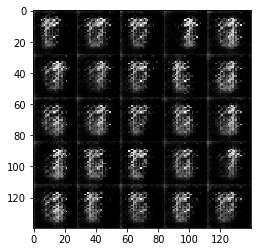

Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.8404
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 1.4641
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 1.3665
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 2.1869
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.8998
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 2.2453
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.4344
Epoch 1/2... Discriminator Loss: 1.6798... Generator Loss: 1.1547


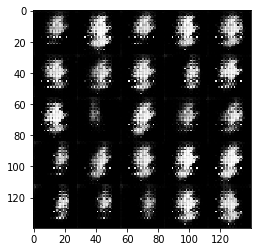

Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.3560
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.2458
Epoch 1/2... Discriminator Loss: 0.5150... Generator Loss: 3.6243
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 3.3571
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 2.0859
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 1.0571
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 2.4198
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.6139


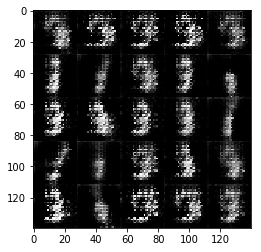

Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.8980
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.6047
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 1.8188
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 1.8374
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.9201
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.5170
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 2.0793
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 2.0400


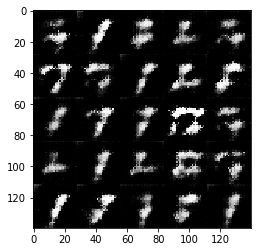

Epoch 1/2... Discriminator Loss: 0.7090... Generator Loss: 1.8390
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 3.6542
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 1.8887
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 2.2400
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 1.8718
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 1.2062
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.6499
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.6009
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.7256


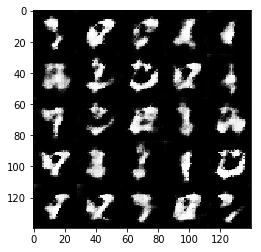

Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 2.5929
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 2.3989
Epoch 1/2... Discriminator Loss: 0.9198... Generator Loss: 1.8949
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 2.0645
Epoch 1/2... Discriminator Loss: 0.8121... Generator Loss: 1.8375
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 1.3081
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 2.4151
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 2.0818
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.6138
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.9486


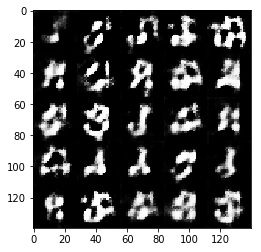

Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 1.4813
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.8585
Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 1.8248
Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.9899
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.7458
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 0.6671... Generator Loss: 1.8682
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 3.0594
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.9447


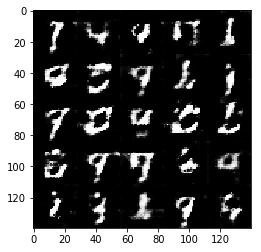

Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 2.2019
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 2.7265
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.5319
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.2917
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 2.3262
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 1.3010
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 2.0002
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 1.7154
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.3054


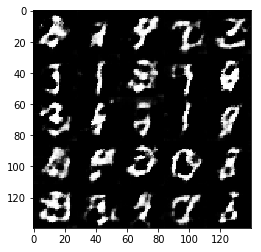

Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.7870
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.5285
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 1.5832
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.5681
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.8187


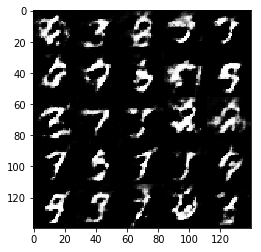

Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 1.0117
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 1.5625
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.0169
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 1.5885
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.3799
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 1.1662
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.2260


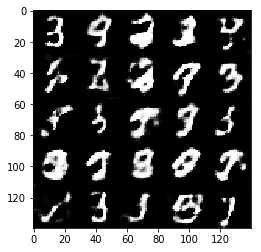

Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 1.0471
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 1.6235
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 1.4503
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 1.1300


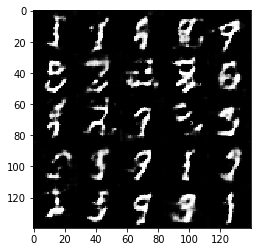

Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.5982
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 1.8417
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 1.4826
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 1.3985


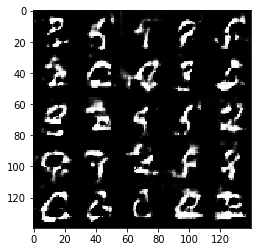

Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 1.2534
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 1.2304
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 1.5714
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.3900
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 0.8538


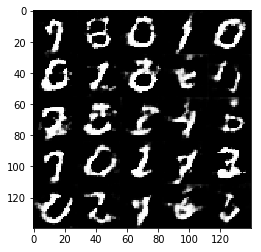

Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.9428
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 1.2056
Epoch 2/2... Discriminator Loss: 1.1801... Generator Loss: 1.2826
Epoch 2/2... Discriminator Loss: 1.2517... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 1.5042
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 1.2053


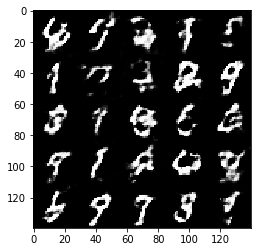

Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 1.5493
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 1.2429
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 1.1237
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 1.3313
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.6155
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.1951


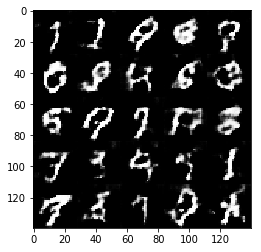

Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 1.5284
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 1.0699
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 1.4762


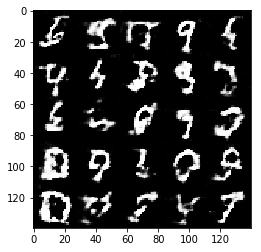

Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 1.2181
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 1.1114
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.8969


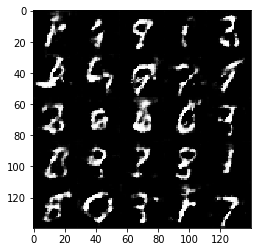

Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 1.1357
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 1.2523
Epoch 2/2... Discriminator Loss: 1.0920... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 1.0626
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 1.1523


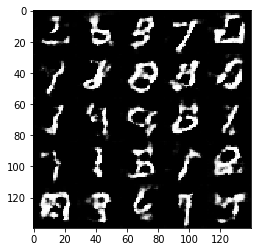

Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 1.0684
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.0047
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 1.3010
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 1.2060
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 1.1124
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 1.0269


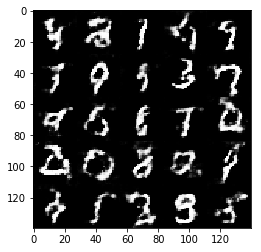

In [15]:
batch_size = 63
z_dim = 100
learning_rate = 0.001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0679... Generator Loss: 0.2032
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 1.7994
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.4481
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 2.5265
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 2.3958
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.4139


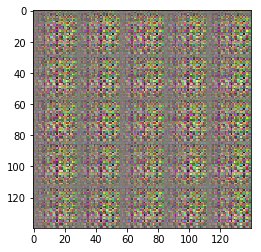

Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.4855
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.7456
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.7765
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 2.8299
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 2.8942
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.5444
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 2.7741
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 2.8977
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 2.9431


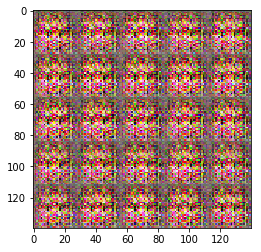

Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 3.0645
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 3.0052
Epoch 1/1... Discriminator Loss: 0.4243... Generator Loss: 2.7366
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 2.9557
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.1132
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 3.2665
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 3.0639
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.1090
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.6305


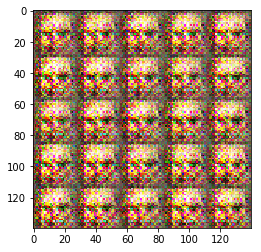

Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 3.2999
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 3.3606
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 2.7097
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 3.1413
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.8145
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 3.0091
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.2708
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 3.1171
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 2.9034
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 3.3595


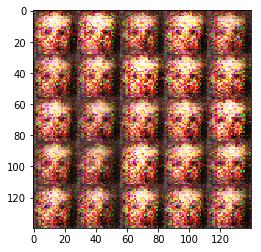

Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 2.3208
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.7068
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.9855
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.6601
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.6788
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.9427
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.8828
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.5856
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.9269


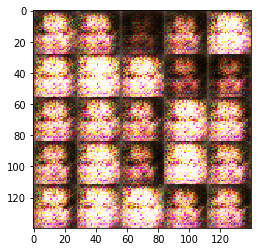

Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 3.1224
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.8461
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.4776
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 2.9112
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.0279
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.4615
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 2.8592
Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 2.5855
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 3.1881
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.4900


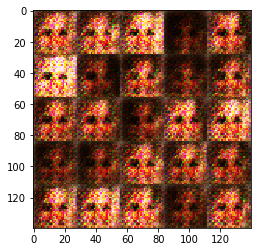

Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 2.5675
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.5123
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.3118
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 2.8443
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 2.5475
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 3.1775
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.7938
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.8078
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 2.8396
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 2.4104


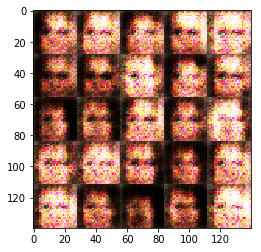

Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 3.5580
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.5867
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 2.2157
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 2.9811
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.9220
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 2.3507
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.4753
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.7706
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 2.4834


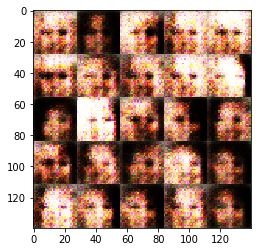

Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.5035
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 3.2879
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.0773
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 2.2758
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.3485
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 2.1078
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.1451
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.6020
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 2.1588


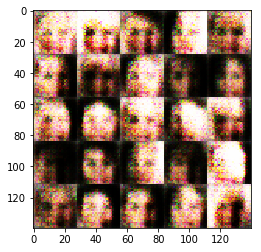

Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.5812
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.5771
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 2.5337
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 2.0426
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 2.2678
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.3551
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.0540
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.1334
Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 2.1235
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.7873


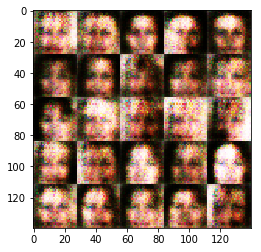

Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 1.7931
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 2.4817
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.8811
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.5066
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 3.0294
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.7386
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.9405
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.1472
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 3.2106


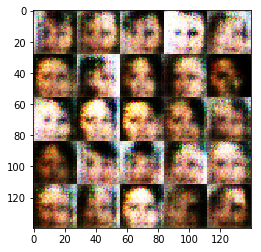

Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.3750
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 2.0574
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 0.5337... Generator Loss: 2.9937
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.1938
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.7614
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.7893
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.3291


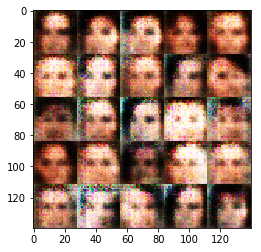

Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.9760
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.4727
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 2.5938
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.1397
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 2.3514
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.7427
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.2342


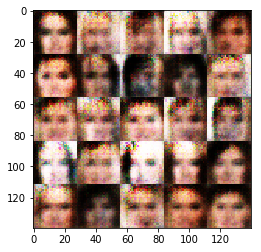

Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 2.0624
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 2.0997
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 2.0933
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.9123
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.9905


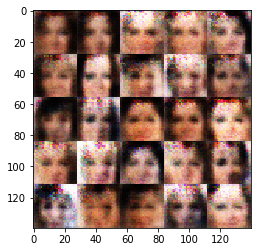

Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 2.2010
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 2.4124
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 3.1252
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.8464
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.6973
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.8880
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.0056
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 2.1263
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 2.0049


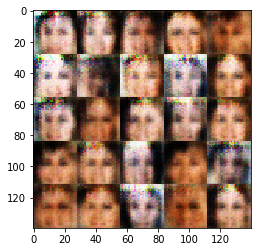

Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 2.2909
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.8548
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.4694
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 2.2560
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 3.0483
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 2.2507
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.2642
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.9376


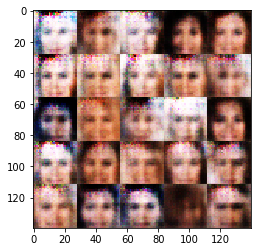

Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 1.9825
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.5918
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.8167
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.1996
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 2.4330
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.4997
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.9239
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 2.4810
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.7942
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 2.1205


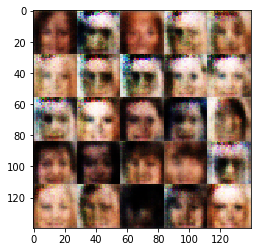

Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.9156
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 2.0624
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.4271
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 2.3370
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 2.5669
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 2.1381
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 3.5634


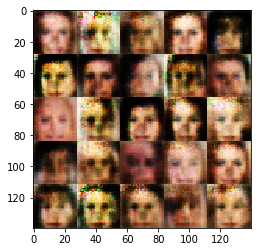

Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.3373
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 3.3372
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.4591
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 2.6908
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 2.4769
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 2.5601
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.3365
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.4183
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.9826


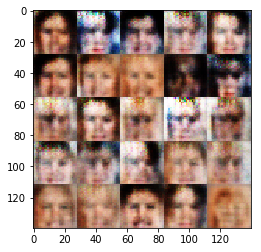

Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.0982
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.0838
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.9352
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.7475
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 2.0207
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 3.0902
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 2.3661
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.9269
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.6478


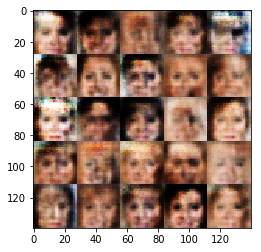

Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.4955
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 2.4989
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.5563
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.2687
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 2.5124
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.6503
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 2.4816
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 2.2991
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.7051
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 2.0166


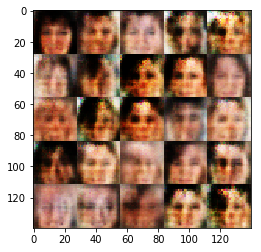

Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 2.9874
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.3943
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 2.8314
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 3.4749
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 1.9258


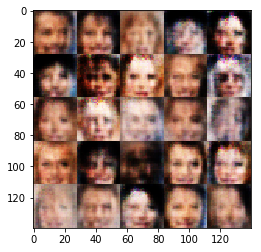

Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.3719
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 2.1729
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 2.5132
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 2.8646
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 3.0609
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 2.1391
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.7688
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 2.1063
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 2.5924


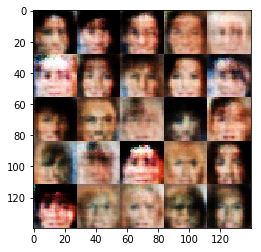

Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.2007
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 2.5891
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 2.9435
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.7922
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.4159
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 2.4845
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.0140
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.8128
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 3.1974
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 2.0173


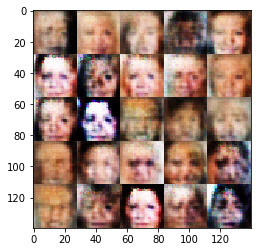

Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 3.7140
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.7885
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.4671
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 3.2792
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 2.6505
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 2.1041
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 2.6828
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.7193


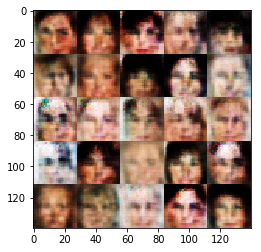

Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.7786
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.1064
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 2.3076
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 3.4031
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.8544
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 3.9689
Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 3.0689
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.9804
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.0895
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.7319


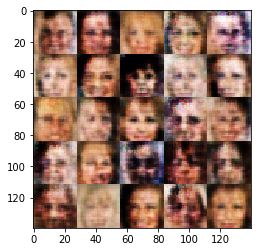

Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.2060
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 3.1030
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.7861
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 2.5993
Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 2.3071
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 2.1641
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 5.2929
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 2.1207
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.5303
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 2.2106


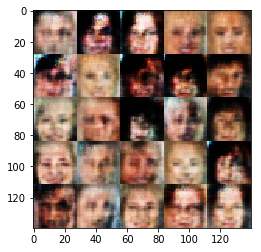

Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.5774
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.7214
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.2759
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 2.8544
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.7163
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 3.0962
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 4.1105
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.2784
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 3.6226


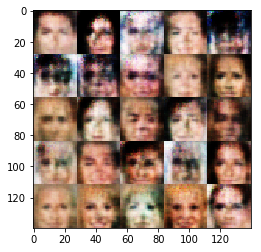

Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.5157
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 2.3900
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 2.0118
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 2.5578
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.2701
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.7533
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 3.2929
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 2.0291
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 2.8618
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.4999


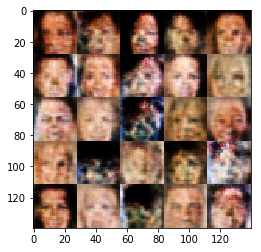

Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.0820
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 2.9110
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 2.2235
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 2.0991
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 1.7215
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 2.9345
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 2.2047
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 2.4276
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.3028


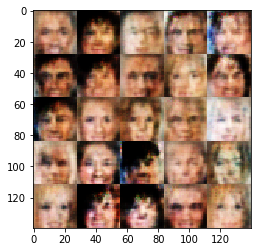

Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.7458
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 2.6085
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.5488
Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 2.1524
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 2.4659
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.9823
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.2558
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 2.1934
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 2.6393


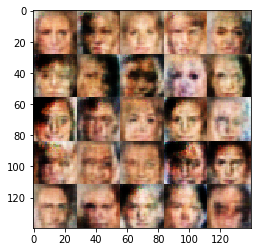

Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.7810
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 2.7592
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.2852
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.5837
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.7978
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 2.2558
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 2.5158
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 2.9272
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.7036


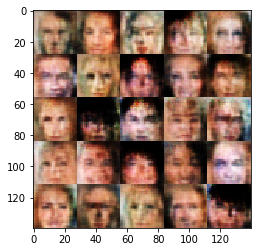

Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 1.9808
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 2.2472
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.8809
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 2.4137
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 2.1698
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 3.3981
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 2.4542
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 2.5850
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.1734


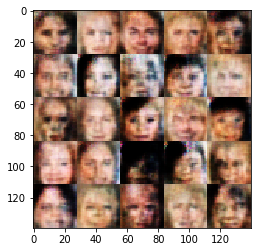

Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 2.9536
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.4036
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.6828
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 2.7152
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 2.1312
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.4919
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 3.9607
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.4738
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 2.1430


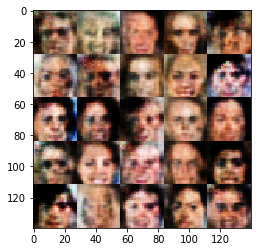

Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 2.1266
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 2.0061
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 2.7649
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 3.1497
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.8452
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.7186
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.2265
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 3.8425
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 1.7014
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.7868


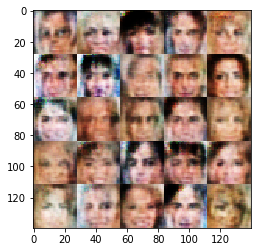

Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 2.3948
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 3.5518
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.7969
Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 2.8202
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 3.3505
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.5494
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.4898
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.6981


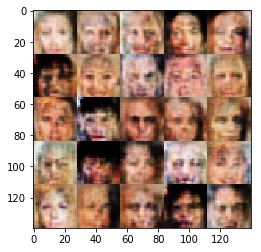

Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 2.4341
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.5157
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 3.2061
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.3813
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 2.1325
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 3.2458
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 2.3826
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 2.8364


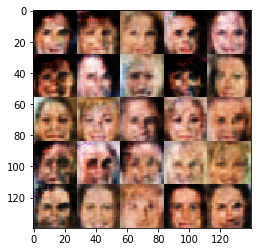

Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 3.2108
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.1629
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.7587
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 2.4661
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.0228
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.5894
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 2.1684
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 2.3795


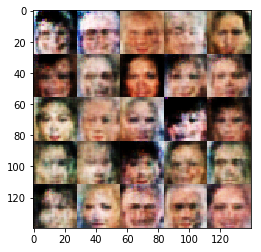

Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.9172
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.4499
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 2.6613
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 2.4164
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 3.2310
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 2.2398
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 2.8343
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 2.2266
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 2.2932


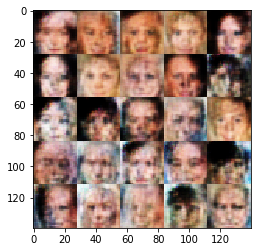

Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.4183
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.8705
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 2.7232
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 3.1821
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.9462
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.3742
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 2.5998
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.7669
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 2.4461


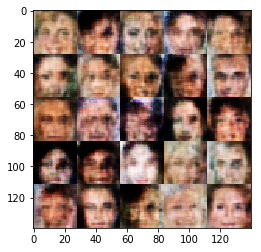

Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.0434
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.3833
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 3.0275
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 2.1726
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.4219
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 2.2621
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 2.6639
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 2.0234
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.7947


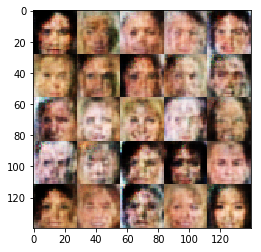

Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 2.6245
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 2.1190
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 2.8363
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 2.6261
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 2.4319
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.2597
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.4690
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.0187


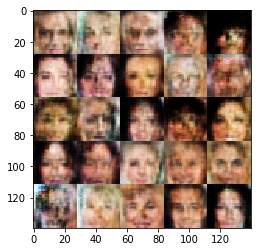

Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.7752
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.0734
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.9446
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.6625
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 3.0374
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 2.1417
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 2.7962


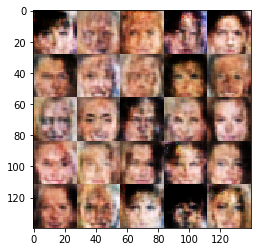

Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.5518
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 2.6947
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 2.4954
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 2.9222
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.6886
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 3.4755
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 3.4449


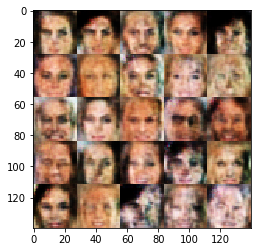

Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 2.3865
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.4627
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.4933
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 2.2023
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.2179
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 2.3803
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 2.5403
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.9760
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.4370
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 2.4718


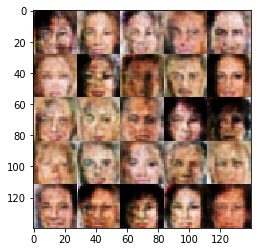

Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 2.6265
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 2.5254
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 2.3207
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.8337
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 2.6845
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.7776
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.6421
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.9274


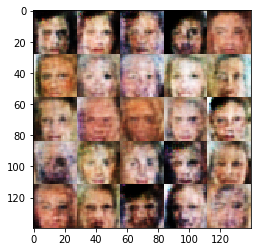

Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 2.8539
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 2.2117
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 1.8812
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.5968
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 1.8511
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 2.8161
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 2.4685
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.9233
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.6775


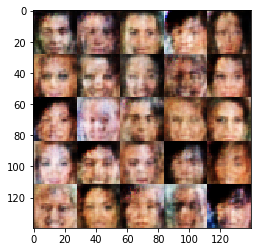

Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 2.4449
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 2.2127
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 2.6614
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 2.7056
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 2.2338
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 2.5825
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.6406
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 2.5059
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.3226


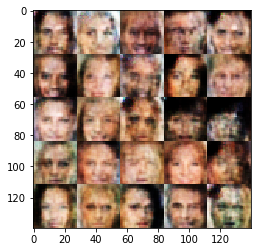

Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 2.5601
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 2.0910
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 2.0921
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 1.9004
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 2.1077
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 2.0078
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.5411
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.4384


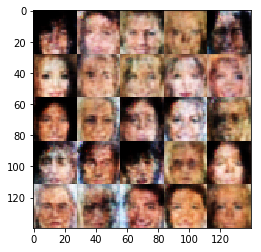

Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 2.5918
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.9957
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.4226
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.4765
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 2.4676
Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 1.9992
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 1.9221
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.6827
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 2.5240


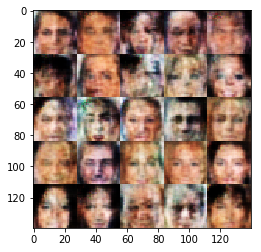

Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 2.2566
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 2.2710
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 2.3268
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 2.3964
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 2.1614
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 3.1891
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 2.2503
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 1.6894


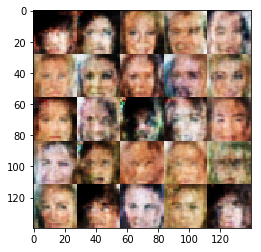

Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.9727
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 2.1618
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.5867
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 2.8125
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 3.2035
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.6987
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 2.3188
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 2.2658


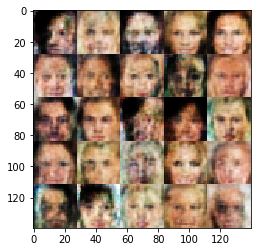

Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.6955
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 2.4507
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.9867
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 2.3869
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 2.0891
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.0574
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 2.2268
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 2.2975
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.2903


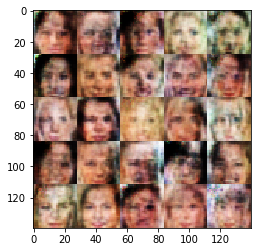

Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 1.8904
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.9440
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 2.3491
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 2.1640
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 2.2444
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.8283


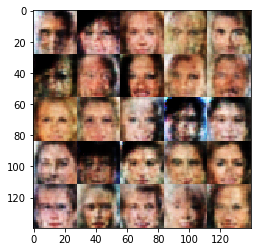

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 2.3849
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 2.5823
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.8987
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 2.1757
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 3.0533
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 2.0665
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 2.7558


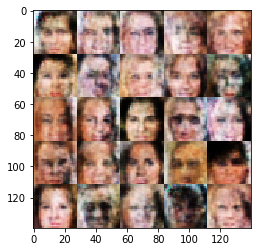

Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 2.1094
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.9021
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.7235
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 2.6245
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 2.0279
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.7135
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.8014
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 2.0172
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 2.5370


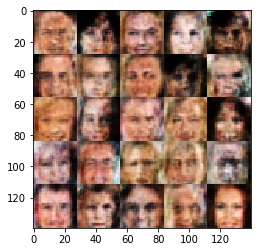

Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 2.1372
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 2.4917
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 2.0154
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 2.3673
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 2.2601
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 2.0445


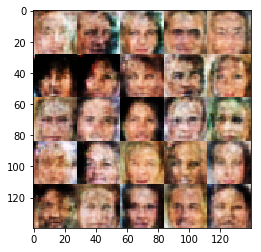

Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 2.2965
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 2.3693
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 2.3125
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 2.3729
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 2.3399
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.7887
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 2.8352


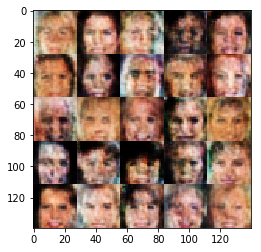

Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.9699
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 2.1874
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 2.6257
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.6725
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 2.1989
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.1600
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 2.1071
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 2.9209


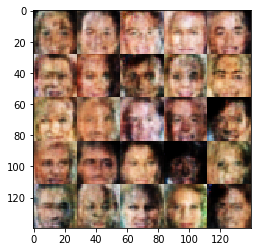

Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.9033
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 2.1307
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 2.1132
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 1.8622
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 2.4822
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 2.0873
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.6928
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.9037
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 2.3351


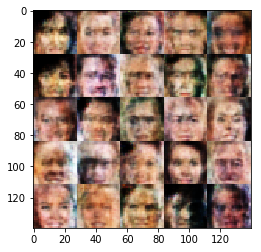

Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 2.3894
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 2.2731
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 2.3037
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 2.1002
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 2.2417
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 2.4324
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 2.6914
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 2.0009
Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 1.8206


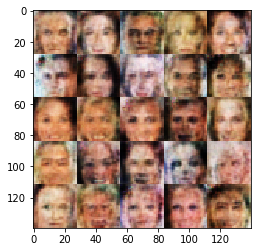

Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.5182
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.7480
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 2.8477
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 2.1814
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 2.1600
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 2.2561
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.8576
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.9078
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 2.7007


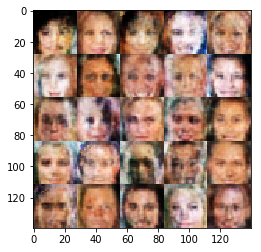

Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 2.1947
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 2.5332
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.5045
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 2.4466
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 2.1876
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.8989
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.8018
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 2.0211


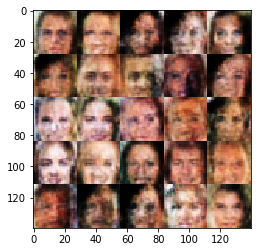

Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 2.4167
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 2.2662


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.